In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
from imutils import contours

In [2]:
# reference image for performing ocr using template matching
# load ocr-a image
ref = cv2.imread("images/ref.png")

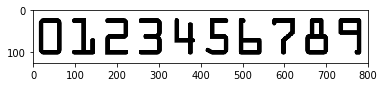

In [3]:
# show the image
plt.imshow(ref)

In [4]:
ref.shape

(126, 800, 3)

In [5]:
# reference image change BGR --> GRAY
ref = cv2.cvtColor(ref,cv2.COLOR_BGR2GRAY)

In [6]:
# thresholding the image
ref = cv2.threshold(ref,10,255,cv2.THRESH_BINARY_INV)[1]

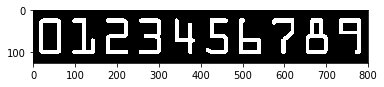

In [7]:
plt.imshow(ref, cmap='gray')

In [8]:
# find contours in the OCR-A image (i.e,. the outlines of the digits)
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [9]:
# new and imp step to grab and sort the contour from left to right,or in any particular direction 
refCnts = imutils.grab_contours(refCnts)
# sorting
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

In [10]:
# digit dictionary to store the values of ocr-a characters
digits = {}

# Now we should have to loop over contour
# resize the roi and store in digits dictionary

for (i, num) in enumerate(refCnts):
    (x, y, w, h) = cv2.boundingRect(num)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    # update the digits dictionary
    digits[i] = roi

In [11]:
# these are the value for each corresponding digit 0 --> 9
print(digits)

{0: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 1: array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 200, ...,   0,   0,   0],
       [  0, 209, 251, ...,   0,   0,   0],
       ...,
       [  0, 228, 255, ..., 255, 252, 233],
       [  0, 216, 242, ..., 253, 216,   0],
       [  0,   0,   0, ..., 210,   0,   0]], dtype=uint8), 2: array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 216, 242, ...,   0,   0,   0],
       [233, 252, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 252, 233],
       [255, 255, 255, ..., 242, 216,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8), 3: array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 200, ...,   0,   0,   0],
       [  0, 209, 251, ...,   0,   0,   0],
       ...,
       [  0, 228, 255, ...,   0,   0,   0]

In [12]:
# initialize a rectangular (wider than it is tall) and square
# We will use the rectangular one for a Top-hat morphological operator 
# and the square one for a closing operation

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

In [13]:
# load the input image
image = cv2.imread("images/target_img.png")
#resize it
image = imutils.resize(image, width=300)
# convert it to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

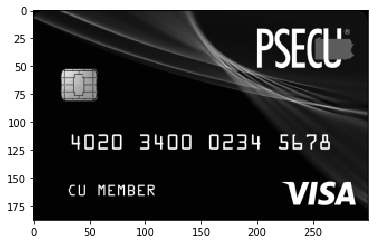

In [14]:
plt.imshow(gray, cmap="gray")

#  Top-hat morphological operation
<a src="https://en.wikipedia.org/wiki/Top-hat_transform">Click here to know more</a>

In mathematical morphology and digital image processing, top-hat transform is an operation that extracts small elements and details from given images. There exist two types of top-hat transform: the white top-hat transform is defined as the difference between the input image and its opening by some structuring element, while the black top-hat transform is defined dually as the difference between the closing and the input image. Top-hat transforms are used for various image processing tasks, such as feature extraction, background equalization, image enhancement, and others.

In [15]:
# apply a tophat (whitehat) morphological operator to find light
# regions against a dark background (i.e., the credit card numbers)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

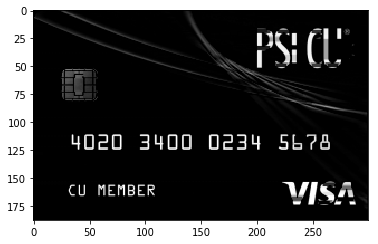

In [16]:
# let see the tophat operation result
plt.imshow(tophat,cmap='gray')

In [17]:
# now use Sobel operator used for edge detection
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

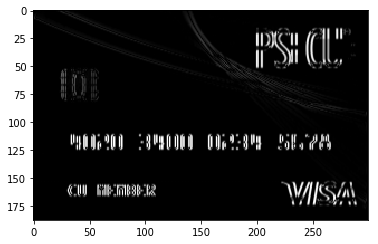

In [18]:
# reult of sobel
plt.imshow(gradX, cmap="gray")

In [19]:
# apply a closing operation using the rectangular kernel to help
# cloes gaps in between credit card number digits

# imp step M --> T --> M
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

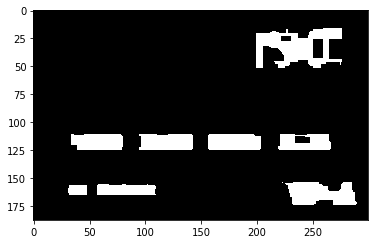

In [20]:
# Thresholding our gradient magnitude representation reveals candidate regions
# for the credit card numbers we are going to OCR.

plt.imshow(thresh, cmap="gray")

In [21]:
# find contours in the thresholded image, then initialize the
# list of digit locations
# using the same method for target img as we do for ref img
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [22]:
locs = []

In [23]:
# Now we want to remove unwanted area and focus only
# on those area which contain credit card number
for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if ar > 2.5 and ar < 4.0:
        # finding the best area to get digits
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            locs.append((x, y, w, h))

In [24]:
# sort it
locs = sorted(locs, key=lambda x:x[0])

In [25]:
output = []

In [26]:
# let see output of locations
print(locs)

# we get 4 points where possibly the digit are present

[(34, 111, 47, 14), (95, 111, 48, 14), (157, 111, 47, 14), (219, 111, 48, 14)]


In [27]:
# loop over the 4 groupings
for (i, (gX, gY, gW, gH)) in enumerate(locs):

    groupOutput = []
    # extract the group ROI of 4 digits from the grayscale image,
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # find the contour
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = imutils.grab_contours(digitCnts)
    
    # sort it
    digitCnts = contours.sort_contours(digitCnts,method="left-to-right")[0]
    
    # loop over the 4 digit contours
    for c in digitCnts:
        # resize digit t to have the same fixed size as
        # the reference OCR-A images
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        
        scores = []
        for (digit, digitROI) in digits.items():
            # apply correlation-based template matching, take the
            # score, and update the scores list
            result = cv2.matchTemplate(roi, digitROI,cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
            
        groupOutput.append(str(np.argmax(scores)))
        
        # Finally, let’s draw a rectangle around each group 
        # and view the credit card number on the image in red text
        
        cv2.rectangle(image, (gX - 5, gY - 5),(gX + gW + 5, gY + gH + 5), (255, 0, 0), 2)
        # Putting text on image
        cv2.putText(image, "".join(groupOutput), (gX, gY - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0, 0), 2)
        
    # update the output digits list
    output.extend(groupOutput)

In [28]:
print(output)

['4', '0', '2', '0', '3', '4', '0', '0', '0', '2', '3', '4', '5', '6', '7', '8']


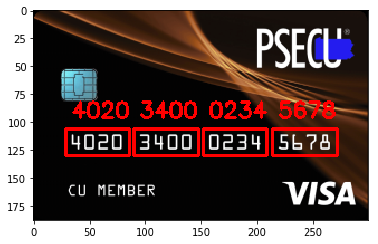

In [29]:
plt.imshow(image)

In [30]:
print("Credit Card No.: {}".format("".join(output)))

Credit Card No.: 4020340002345678
